In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.regress import *
from aeons.endpoint import *
from aeons.plotting import *
figsettings()

In [218]:
def beta_DKL(points, ndead):
    logX = points.logX().iloc[ndead]
    if logX < -points.D_KL():
        return 1
    def func(beta):
        return logX + points.set_beta(beta).D_KL()
    from scipy import optimize
    res = optimize.root_scalar(func, bracket=[0, 1])
    return res.root


def logprior(x, mu, sig):
    return -0.5*np.log(2*np.pi*sig**2) - np.power((x - mu)/sig, 2)/2

In [333]:
name, samples = get_samples('toy', 'cauchy_83')
model = EndModel(samples)
true_endpoint = model.true_endpoint()

In [334]:
true_endpoint

29961

In [378]:
ndead = 20000
logL, X_mean, nk, logZdead = model.data(ndead)
points = points_at_iteration(samples, ndead)
beta = beta_DKL(points, ndead)
dG = points.set_beta(beta).d_G(25).values
dG_mean = np.mean(dG)
dG_std = np.std(dG)

logLd, Xd = logL[ndead:], X_mean[ndead:]
N = len(logLd)

In [379]:
Nset = 25
theta_ds = np.zeros(Nset)
for i, d in enumerate(theta_ds):
    X = generate_Xs(nk)
    theta_ds[i] = analytic_lm_params(logLd, X[ndead:], d0=1)[1]
theta_ds = theta_ds[~np.isnan(theta_ds)]
theta_ds = reject_outliers(theta_ds, 2)
theta_ds.mean(), theta_ds.std()

(50.10615199285429, 39.00043819408374)

3.906308025431654

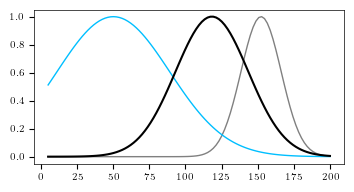

In [380]:
ds = np.linspace(5, 200, 100)
logp_dG = logprior(ds, dG_mean, dG_std)
logp_d = logprior(ds, theta_ds.mean(), theta_ds.std())

d_weight = dG_mean/theta_ds.std()
logpost = (logp_dG + d_weight*logp_d)/(1 + d_weight)
plt.plot(ds, np.exp(logp_dG - logp_dG.max()), lw=1, color='gray')
plt.plot(ds, np.exp(logp_d - logp_d.max()), lw=1, color='deepskyblue')

plt.plot(ds, np.exp(logpost - logpost.max()), color='black')
d_weight

In [387]:
d_infer = (np.exp(logpost - logpost.max()) * ds).sum() / np.exp(logpost - logpost.max()).sum()
d_infer_std = np.sqrt((np.exp(logpost - logpost.max()) * (ds - d_infer)**2).sum() / np.exp(logpost - logpost.max()).sum())
theta_infer = params_from_d(logLd, Xd, 60)
theta_infer_plus = params_from_d(logLd, Xd, 125)

In [388]:
logL, X_mean, nk, logZdead = model.data(ndead)
logXf_formula(theta_infer, logZdead, X_mean[ndead]), logXf_formula(theta_infer_plus, logZdead, X_mean[ndead])

(-63.342827754256874, -74.215362424584)

In [383]:
samples.logX().iloc[true_endpoint]

-59.86415577902847